In [9]:
import numpy as np
from tqdm import tqdm
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../..")
from ecit import *



def ecitSimulateAlpha(methods, 
                 zDis_list=['gaussian'], 
                 noiseDis_list =['laplace'], 
                 n_list=[1200], 
                 t=10000):
    
    results_table = []

    for n in n_list:
        for zDis in zDis_list:
            for cit, k, p_ensemble in methods:
                row =  [n, zDis.capitalize(), cit.__name__ + str(k) + p_ensemble[0].__name__ if isinstance(p_ensemble, list) else cit.__name__ + str(k) + p_ensemble.__name__]

                for noiseDis in tqdm(noiseDis_list, desc=f"{n:>5}, {zDis:>8}, {k:>3},{p_ensemble[0].__name__ if isinstance(p_ensemble, list) else p_ensemble.__name__ :>11}"):
                    if isinstance(p_ensemble, list):
                        eI = np.array([0]*len(p_ensemble))
                        eII = np.array([0]*len(p_ensemble))
                        for i in range(t):
                            retries = 0
                            while retries < 5:
                                try:
                                    dataI = np.hstack((generate_samples(n=n,indp='C',z_dis=zDis, noise_dis=noiseDis,noise_std=1)))
                                    dataII = np.hstack((generate_samples(n=n,indp='N',z_dis=zDis, noise_dis=noiseDis,noise_std=1)))
                                    obj_ECIT = ECIT(dataI, cit, p_ensemble, k if k<100 else int(n/k))
                                    pI = obj_ECIT([0], [1], [2], multi=True)
                                    obj_ECIT = ECIT(dataII, cit, p_ensemble, k if k<100 else int(n/k))
                                    pII = obj_ECIT([0], [1], [2], multi=True)
                                    break
                                except Exception as e:
                                    retries += 1
                                    print(f"Retries times {retries}")
                                    if retries >= 5: raise e
                            eI += (np.array(pI) < 0.05).astype(int)
                            eII += (np.array(pII) > 0.05).astype(int)
                        eI = eI/t
                        power = (t - eII)/t
                        row.append(eI)
                        row.append(power)
                    else:
                        eI = 0
                        eII = 0
                        for i in range(t):
                            retries = 0
                            while retries < 5:
                                try:
                                    dataI = np.hstack((generate_samples(n=n,indp='C',z_dis=zDis, noise_dis=noiseDis,noise_std=1)))
                                    dataII = np.hstack((generate_samples(n=n,indp='N',z_dis=zDis, noise_dis=noiseDis,noise_std=1)))
                                    obj_ECIT = ECIT(dataI, cit, p_ensemble, k if k<100 else int(n/k))
                                    pI = obj_ECIT([0], [1], [2], multi=isinstance(p_ensemble, list))
                                    obj_ECIT = ECIT(dataII, cit, p_ensemble, k if k<100 else int(n/k))
                                    pII = obj_ECIT([0], [1], [2], multi=isinstance(p_ensemble, list))
                                    break
                                except Exception as e:
                                    retries += 1
                                    print(f"Retries times {retries}")
                                    if retries >= 5: raise e
                            if pI<0.05:
                                eI += 1
                            if pII>0.05:
                                eII += 1
                        eI = eI/t
                        power = (t - eII)/t
                        row.append(eI)
                        row.append(power) 
                results_table.append(row)

    return results_table

In [ ]:
enplist = [p_alpha2, p_alpha175, p_alpha15, p_alpha125, p_alpha1, p_alpha075, p_alpha05, p_alpha025, p_alpha01, p_mean]
ensCIT = [(kcit, 400, enplist)]
results = ecitSimulateAlpha(ensCIT, n_list=[1200], t=10000)
results

 1200, gaussian, 400,   p_alpha2: 100%|██████████| 1/1 [3:22:05<00:00, 12125.48s/it]


[[1200,
  'Gaussian',
  'kcit400p_alpha2',
  array([0.0507, 0.0507, 0.0514, 0.0548, 0.0545, 0.0537, 0.0525, 0.0522,
         0.052 , 0.0002]),
  array([0.954 , 0.9526, 0.9505, 0.9468, 0.9434, 0.941 , 0.9394, 0.9384,
         0.9382, 0.8787])]]

In [101]:
eI = [0.0507, 0.0507, 0.0514, 0.0548, 0.0545, 0.0537, 0.0525, 0.0522, 0.0002]
meanI = eI.pop()
eII = [0.954 , 0.9526, 0.9505, 0.9468, 0.9434, 0.941 , 0.9394, 0.9384, 0.8787]
meanII = eII.pop()
x = list(np.array(range(1,9))/4)
eI = eI[::-1]
eII = eII[::-1]

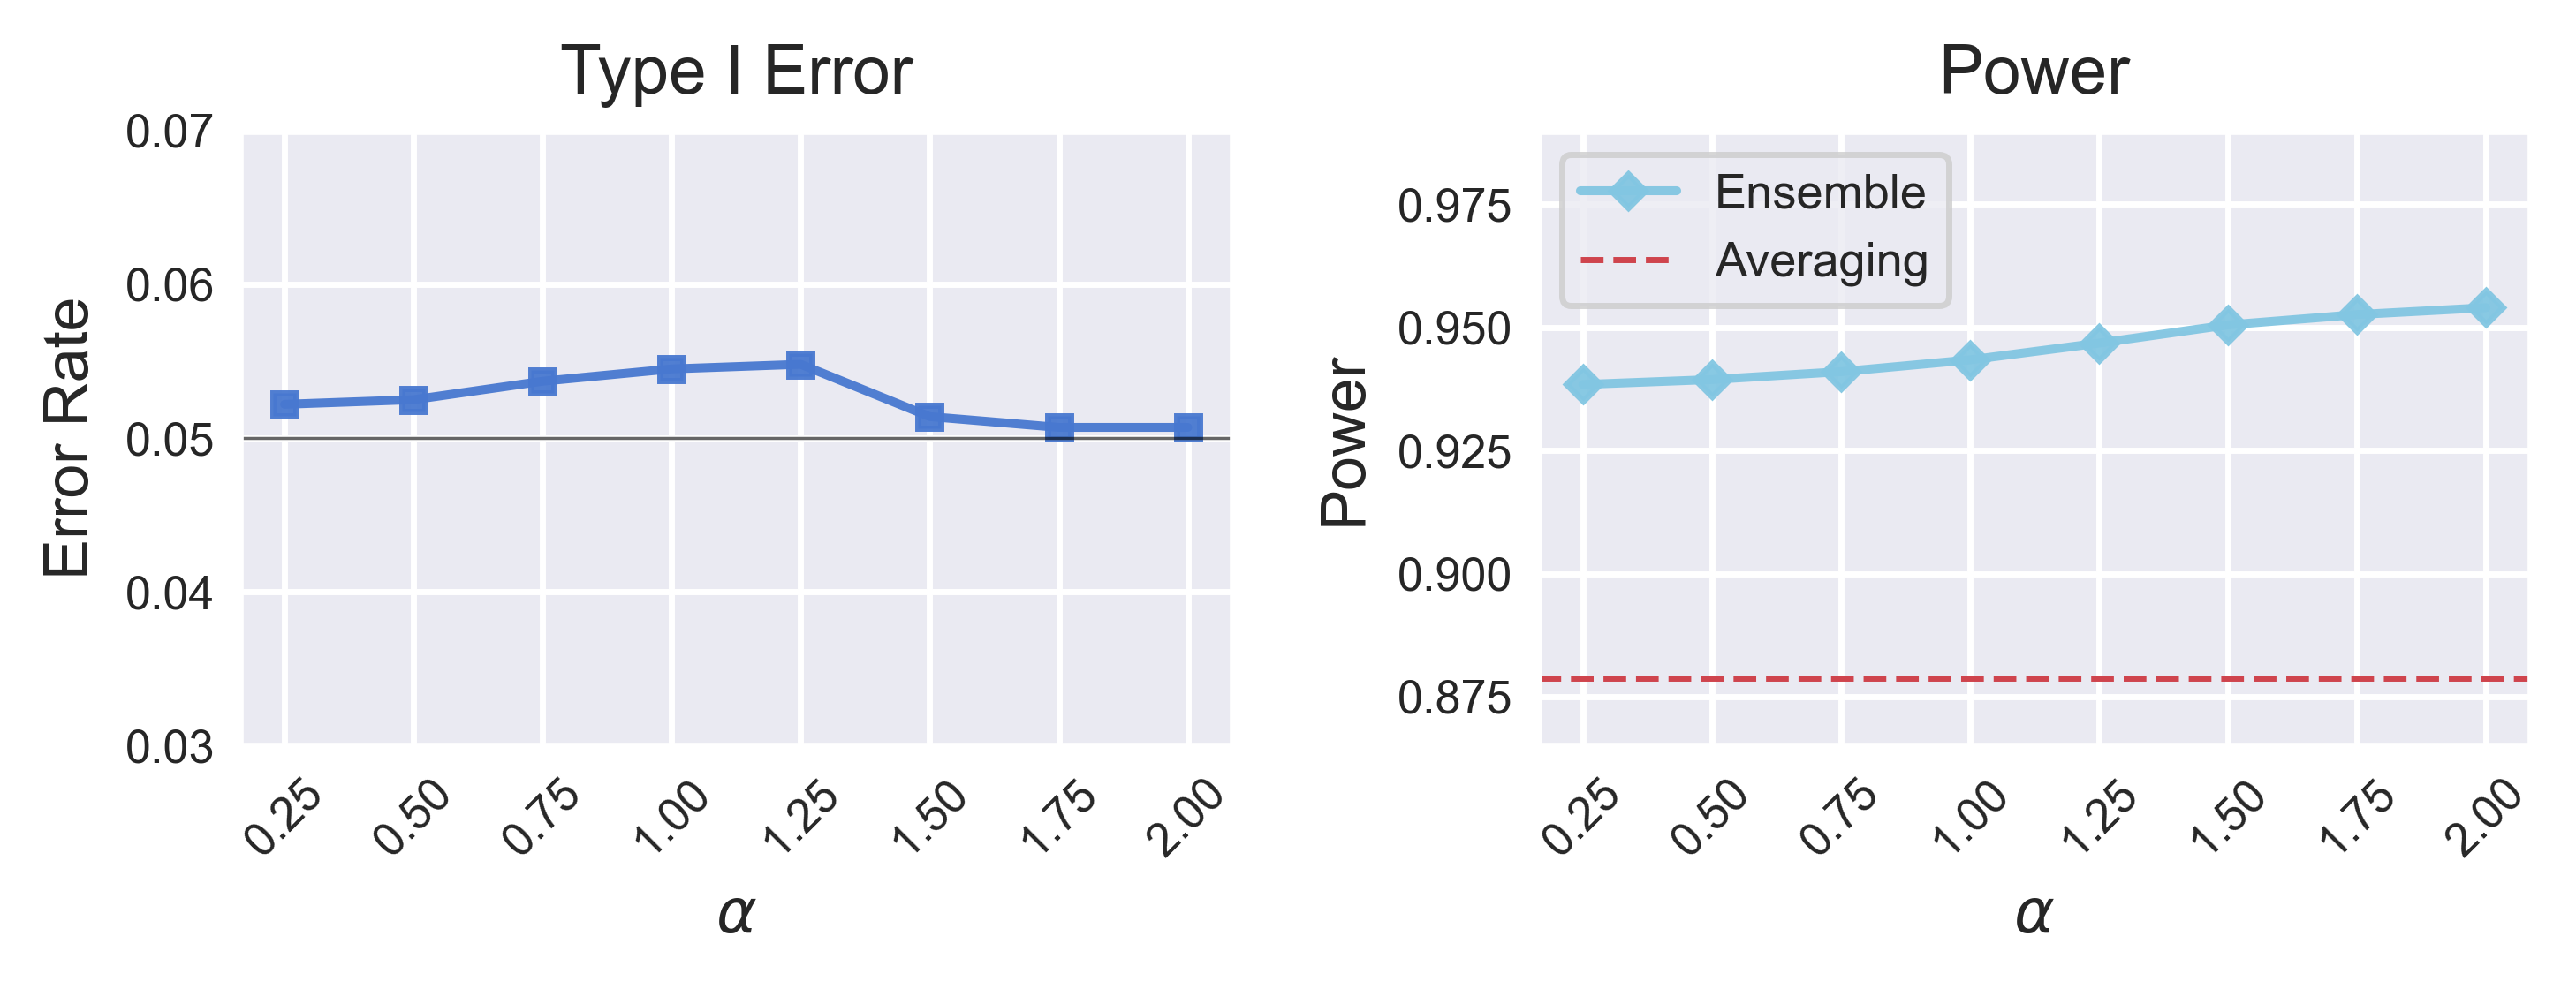

In [109]:
sns.set()
alpha = 0.95
markersize = 3.8
linewidth = 1.45

fig, axes = plt.subplots(1, 2, figsize=(6, 2.4), dpi=500)

linestyles = ['--', '-', '-']
markers = ['^', 's', 'D']
colors = ["#cf444d", sns.color_palette("muted")[0], sns.color_palette("muted")[9]]  # 颜色
i = 1
axes[0].plot(x, eI, alpha=alpha, label='Type I Error', linestyle=linestyles[i], marker=markers[i], markersize=markersize, linewidth=linewidth, color=colors[i])



i = 2
axes[1].plot(x, eII, alpha=alpha, label='Ensemble', linestyle=linestyles[i], marker=markers[i], markersize=markersize, linewidth=linewidth, color=colors[i])

axes[1].axhline(y=meanII, color="#cf444d", linestyle='--', linewidth=1, label='Averaging')
axes[1].legend(loc='upper left', fontsize=7.8, ncol=1)


ax_eI, ax_eII = axes

ax_eI.set_xticks(x)
ax_eII.set_xticks(x)
ax_eI.set_ylim(0.03, 0.07)
ax_eII.set_ylim(0.865, 0.99)
ax_eII.set_yticks([0.875, 0.9, 0.925, 0.95, 0.975]) 
ax_eI.tick_params(axis='x', labelsize=7.5, pad=-2, rotation=45)
ax_eII.tick_params(axis='x', labelsize=7.5, pad=-2, rotation=45)
ax_eI.tick_params(axis='y', labelsize=7.5, pad=-2)
ax_eII.tick_params(axis='y', labelsize=7.5, pad=-2)


ax_eI.axhline(y=0.05, color='black', linestyle='-', alpha=0.6, linewidth = 0.5, label='Significance level')

ax_eI.set_title("Type I Error", fontsize=11)
ax_eI.set_ylabel("Error Rate", fontsize=10)

ax_eII.set_title("Power", fontsize=11)
ax_eII.set_ylabel("Power", fontsize=10)


ax_eI.set_xlabel(r"$\alpha$", fontsize=10)
ax_eII.set_xlabel(r"$\alpha$", fontsize=10)


plt.tight_layout()
plt.savefig("alpha.pdf", format='pdf')
plt.show()

